In [ ]:
import pandas as pd

df = pd.read_csv('Cars.comScraped.csv')

print(df.info())
print(df.isnull().sum())
print(df.head())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10216 entries, 0 to 10215
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   10216 non-null  object 
 1   Dealer                  10082 non-null  object 
 2   Location                0 non-null      float64
 3   State                   10060 non-null  object 
 4   Rating                  9841 non-null   float64
 5   Link                    10216 non-null  object 
 6   Exterior Color          10204 non-null  object 
 7   Interior Color          10204 non-null  object 
 8   Drivetrain              10204 non-null  object 
 9   MPG                     9243 non-null   object 
 10  Fuel Type               9373 non-null   object 
 11  Transmission            10204 non-null  object 
 12  Engine                  10204 non-null  object 
 13  VIN                     10204 non-null  object 
 14  Stock#                  10070 non-null

# Data Cleaning

Scraped data from Cars.com to be cleaned:

1. Remove Duplicates
2. Handle missing values
3. Drop unecessary rows
4. fix dtypes, create more columns for robust features
5. Encode data for model training

# Remove Duplicates

Remove duplicates is a complex function to meticulously remove duplicates based on Vin (if available, else it falls back onto stock#, etc).

This gives a better chance to keep important rows and also work with a large dataset

In [ ]:
def remove_duplicates(df):
    def deduplicate(group):
        if group['VIN'].notna().any():  #If at least one VIN is not null
            return group.drop_duplicates(subset=['VIN'])
        elif group['Stock#'].notna().any():  #If at least one Stock Number is not null
            return group.drop_duplicates(subset=['Stock#'])
        elif group['Mileage'].notna().any():  #If at least one Mileage is not null
            return group.drop_duplicates(subset=['Mileage'])
        else:  #If VIN, Stock Number, and Mileage are all null, use Dealership and Price
            return group.drop_duplicates(subset=['Dealer', 'Price'])

    return df.groupby('Title', group_keys=False).apply(deduplicate).reset_index(drop=True)

df = remove_duplicates(df)

print(df.shape)

(9204, 21)


<ipython-input-2-203ed7a7751a>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Title', group_keys=False).apply(deduplicate).reset_index(drop=True)


# Drop unecessary rows


In [ ]:
df = df.drop(columns=['VIN', 'Stock#', 'Location', 'Link'], errors='ignore')

# Extract and create more Features

In [ ]:
df['Year'] = df['Title'].apply(lambda x: int(x.split(' ')[0])) # extracting the year from title
df['Title'] = df['Title'].str.replace(r'\d{4}', '', regex=True).str.strip() # removing year from title

In [ ]:
import datetime
current_year = datetime.datetime.now().year

df['Car Age'] = current_year - df['Year'] # Car age based on df['Year'] and current year

In [ ]:
df['Make'] = df['Title'].str.split().str[0] # extract the make from title

# Handle Missing Values

In [ ]:
def impute_missing_state(df):
    #Iterate over each dealer
    for dealer, group in df.groupby('Dealer'):
        #Get rows where state is missing
        missing_state_rows = group[group['State'].isnull()]

        if not missing_state_rows.empty:
            #Get the most frequent state for the dealer
            known_states = group[group['State'].notnull()]['State']

            if not known_states.empty:
                #Get the most common state for this dealer
                most_common_state = known_states.mode()[0]

                #Fill missing states with the most common state for the dealer
                df.loc[(df['Dealer'] == dealer) & (df['State'].isnull()), 'State'] = most_common_state

    #Replace any remaining missing States witH UN (Unknown)
    df['State'].fillna('UN', inplace=True)

    return df

df = impute_missing_state(df)

<ipython-input-7-6aaddc09cbe2>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['State'].fillna('UN', inplace=True)


In [ ]:
df.head(20)

,Title,Dealer,State,Rating,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Mileage,Convenience Features,Entertainment Features,Exterior Features,Safety Features,Price,Year,Car Age,Make
0,Chrysler F-58,Gateway Classic Cars,IL,2.4,Red,White,–,0–0\nBased on EPA mileage ratings. Use for com...,–,3-Speed Manual,4 Cylinder,"28,300 mi.",NaN,NaN,NaN,NaN,"$11,500\n\n\n $1,000 price drop",1926,99,Chrysler
1,Ford Model A Base,Skyway Classics,FL,2.9,Magenta,Tan,–,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,automatic,350 V8,"17,089 mi.",NaN,NaN,NaN,NaN,"$35,997",1930,95,Ford
2,Ford Pickup Truck Base,Greenwood Automotive,CO,4.9,–,–,–,0–0\nBased on EPA mileage ratings. Use for com...,–,Manual,–,"150,140 mi.",NaN,NaN,NaN,NaN,"$89,995",1940,85,Ford
3,Chevrolet Fleetline Deluxe,California Cars,CA,0.0,Atomic Orange Metallic,Gray,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,Automatic,283 V8,437 mi.,NaN,NaN,NaN,NaN,"$29,900",1951,74,Chevrolet
4,GMC Suburban,Exotic Motorsports of Oklahoma,OK,0.0,Black,Tan,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,–,Automatic 700R4,5.7L V8,570 mi.,NaN,NaN,NaN,NaN,"$49,947\n\n\n $5,000 price drop",1952,73,GMC
5,Chevrolet Bel Air,Joe Basil Chevrolet,NY,4.1,–,–,–,–,–,–,–,"14,633 mi.",NaN,NaN,NaN,NaN,"$65,979",1955,70,Chevrolet
6,Chevrolet Bel Air Base,Marino Performance Motors,FL,0.0,India Ivory and Cashmere Blue,–,–,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,Two-Speed Automatic (Powerglide),265ci V8,460 mi.,NaN,NaN,NaN,NaN,"$99,900",1955,70,Chevrolet
7,Chevrolet 210 Base,Salem Autosports,WI,2.8,Burgundy,Burgundy,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,Automatic,327 cui V8,692 mi.,NaN,NaN,NaN,NaN,"$39,995",1956,69,Chevrolet
8,Ford F100 Base,Exotic Car Trader,FL,4.4,Metallic Blue,Blue,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,3-Speed Automatic,429ci V8,"1,005 mi.",NaN,NaN,NaN,NaN,"$42,999",1956,69,Ford
9,Ford Thunderbird Base,Motorcar Classics,NY,4.3,Coral Sand,Tuxedo,–,0–0\nBased on EPA mileage ratings. Use for com...,–,Automatic,–,"76,096 mi.",NaN,NaN,NaN,NaN,"$61,900",1957,68,Ford


# Handle Missing Values (cont'd)

In [ ]:
median_rating = df['Rating'][df['Rating'] != 0].median()

# Replace zeros and NaN with the median
df['Rating'] = df['Rating'].replace(0, median_rating)
df['Rating'] = df['Rating'].fillna(median_rating)

In [ ]:
df['Dealer'] = df['Dealer'].fillna('Unknown Dealer')
df['Exterior Color'] = df['Exterior Color'].fillna('Unknown')
df['Interior Color'] = df['Interior Color'].fillna('Unknown')
df['Transmission'] = df['Transmission'].fillna('Unknown')
df['Engine'] = df['Engine'].fillna('Unknown')
df['Convenience Features'] = df['Convenience Features'].fillna('Unknown')
df['Entertainment Features'] = df['Entertainment Features'].fillna('Unknown')
df['Exterior Features'] = df['Exterior Features'].fillna('Unknown')
df['Safety Features'] = df['Safety Features'].fillna('Unknown')

In [ ]:
df['Dealer'].value_counts()

,count
Dealer,
Unknown Dealer,122
Utter Family of Dealerships,34
Kendall Ford of Eugene,31
Gallatin Subaru,31
ALM Hyundai Lumberton,28
...,...
Federico Dodge Chrysler Jeep RAM,1
Showcase Auto Sales,1
Uinta CDJR,1


# Simplify Values for better understanding

In [ ]:
import numpy as np

# Replacing values
df['Drivetrain'] = df['Drivetrain'].replace({
    '–': np.nan,
    'Unknown': np.nan,
    'AWD': 'All-wheel Drive',
    'FWD': 'Front-wheel Drive',
    '4WD': 'Four-wheel Drive',
    'All Wheel Drive': 'All-wheel Drive'
})
# Handle missing values
df['Drivetrain'] = df['Drivetrain'].fillna(df['Drivetrain'].mode()[0])

df['Drivetrain'].unique()

array(['All-wheel Drive', 'Rear-wheel Drive', 'Four-wheel Drive',
       'Front-wheel Drive'], dtype=object)

In [ ]:
# Removing extra text
df['MPG'] = df['MPG'].str.replace(r'\n.*', '', regex=True)
df['MPG'] = df['MPG'].str.strip()

# Split the MPG range into two columns (lower and upper values)
df[['MPG_Lower', 'MPG_Upper']] = df['MPG'].str.split('–', expand=True)

# Convert both to numeric
df['MPG_Lower'] = pd.to_numeric(df['MPG_Lower'], errors='coerce')
df['MPG_Upper'] = pd.to_numeric(df['MPG_Upper'], errors='coerce')

df = df.drop('MPG', axis=1) # Drop MPG to prevent redunduncy

In [ ]:
# Handle missing values
df['MPG_Lower'].fillna(df['MPG_Lower'].median(), inplace=True)
df['MPG_Upper'].fillna(df['MPG_Upper'].median(), inplace=True)

<ipython-input-14-b6a81fec79cf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MPG_Lower'].fillna(df['MPG_Lower'].median(), inplace=True)
<ipython-input-14-b6a81fec79cf>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [ ]:
# Replace values for simplifiaction
df['Fuel Type'] = df['Fuel Type'].replace({
    '–': np.nan,
    'Unspecified': np.nan,
    'PHEV (plug-in hybrid electric vehicle)': 'Hybrid',
    'Gas Hybrid': 'Hybrid',
    'Plug-In Hybrid': 'Hybrid',
    'Gaseous': 'Gasoline'
})

df['Fuel Type'] = df['Fuel Type'].fillna(df['Fuel Type'].mode()[0])

df['Fuel Type'].unique()

array(['Gasoline', 'Diesel', 'E85 Flex Fuel', 'Hybrid', 'All-Electric'],
      dtype=object)

In [ ]:
df['Transmission'] = df['Transmission'].fillna('Unknown') # Replace with Unknown first

# Standardize Text
df['Transmission'] = df['Transmission'].astype(str).str.lower().str.strip()

# Categorize Data into Automatic, Manual, Semi-Automatic, and Unclassified
def categorize_transmission(row):
    if any(keyword in row for keyword in ['automatic', 'Automatic', 'Auto', 'auto', 'A/T', 'a/t', 'cv', 'A', '1A', '8A']):
        return 'Automatic'
    elif 'manual' in row or 'm/t' in row or 'M/T' in row or 'Manual' in row:
        return 'Manual'
    elif any(keyword in row for keyword in ['dual', 'clutch', 'sportmatic', 'pdk', 'dsg', 'shiftable', 'geartronic', 'tiptronic', 'steptronic', 'eco', 'powershift', 'Sport', 'sport']):
        return 'Semi-Automatic'
    else:
        return 'Unclassified'

df['Transmission'] = df['Transmission'].apply(categorize_transmission)

print(df['Transmission'].unique())

['Manual' 'Automatic' 'Unclassified' 'Semi-Automatic']


In [ ]:
# Cleaning Mileage column
df['Mileage'] = df['Mileage'].str.replace(',', '', regex=False)  # remove commas
df['Mileage'] = df['Mileage'].str.replace(' mi.', '', regex=False)  # remove ' mi.'
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')  # convert to numeric

In [ ]:
df['Mileage'] = df['Mileage'].fillna(df['Mileage'].median()) # Handle missing values (HMV)

In [ ]:
import re

# Function to extract the first dollar amount
def clean_price(price):
    match = re.search(r'\$\d{1,3}(?:,\d{3})*(?:\.\d{2})?', str(price))
    return match.group(0) if match else None

df['Price'] = df['Price'].apply(clean_price)

df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
df['Price'] = df['Price'].fillna(df['Price'].median()) # HMV

In [ ]:
df.head(20)

,Title,Dealer,State,Rating,Exterior Color,Interior Color,Drivetrain,Fuel Type,Transmission,Engine,...,Convenience Features,Entertainment Features,Exterior Features,Safety Features,Price,Year,Car Age,Make,MPG_Lower,MPG_Upper
0,Chrysler F-58,Gateway Classic Cars,IL,2.4,Red,White,All-wheel Drive,Gasoline,Manual,4 Cylinder,...,Unknown,Unknown,Unknown,Unknown,11500.0,1926,99,Chrysler,0.0,0.0
1,Ford Model A Base,Skyway Classics,FL,2.9,Magenta,Tan,All-wheel Drive,Gasoline,Automatic,350 V8,...,Unknown,Unknown,Unknown,Unknown,35997.0,1930,95,Ford,0.0,0.0
2,Ford Pickup Truck Base,Greenwood Automotive,CO,4.9,–,–,All-wheel Drive,Gasoline,Manual,–,...,Unknown,Unknown,Unknown,Unknown,89995.0,1940,85,Ford,0.0,0.0
3,Chevrolet Fleetline Deluxe,California Cars,CA,4.6,Atomic Orange Metallic,Gray,Rear-wheel Drive,Gasoline,Automatic,283 V8,...,Unknown,Unknown,Unknown,Unknown,29900.0,1951,74,Chevrolet,0.0,0.0
4,GMC Suburban,Exotic Motorsports of Oklahoma,OK,4.6,Black,Tan,Rear-wheel Drive,Gasoline,Automatic,5.7L V8,...,Unknown,Unknown,Unknown,Unknown,49947.0,1952,73,GMC,0.0,0.0
5,Chevrolet Bel Air,Joe Basil Chevrolet,NY,4.1,–,–,All-wheel Drive,Gasoline,Unclassified,–,...,Unknown,Unknown,Unknown,Unknown,65979.0,1955,70,Chevrolet,21.0,28.0
6,Chevrolet Bel Air Base,Marino Performance Motors,FL,4.6,India Ivory and Cashmere Blue,–,All-wheel Drive,Gasoline,Automatic,265ci V8,...,Unknown,Unknown,Unknown,Unknown,99900.0,1955,70,Chevrolet,0.0,0.0
7,Chevrolet 210 Base,Salem Autosports,WI,2.8,Burgundy,Burgundy,Rear-wheel Drive,Gasoline,Automatic,327 cui V8,...,Unknown,Unknown,Unknown,Unknown,39995.0,1956,69,Chevrolet,0.0,0.0
8,Ford F100 Base,Exotic Car Trader,FL,4.4,Metallic Blue,Blue,Rear-wheel Drive,Gasoline,Automatic,429ci V8,...,Unknown,Unknown,Unknown,Unknown,42999.0,1956,69,Ford,0.0,0.0
9,Ford Thunderbird Base,Motorcar Classics,NY,4.3,Coral Sand,Tuxedo,All-wheel Drive,Gasoline,Automatic,–,...,Unknown,Unknown,Unknown,Unknown,61900.0,1957,68,Ford,0.0,0.0


In [ ]:
# Remove rows with cars that are less than 0 years old
df = df[df['Car Age'] >= 0]

# Remove rows with abnormally high Mileage
df = df[df['Mileage'] < 500000]

# Remove rows with abnormally high Price
df = df[df['Price'] < 1000000]

In [ ]:
# Ensure correct dtypes
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Car Age'] = pd.to_numeric(df['Car Age'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

In [ ]:
# Engine column simplification
def simplify_engine(engine_desc):
    engine_desc = engine_desc.lower()
    if 'electric' in engine_desc:
        return 'Electric'
    elif 'hybrid' in engine_desc:
        return 'Hybrid'
    elif 'flexible fuel' in engine_desc:
        return 'Flexible Fuel'
    elif 'gasoline' in engine_desc:
        return 'Gasoline'
    else:
        return 'Other'

df['EngineType'] = df['Engine'].apply(simplify_engine)
print(df['EngineType'].value_counts())

EngineType
Other            5012
Gasoline         2860
Electric          779
Hybrid            468
Flexible Fuel      70
Name: count, dtype: int64


In [ ]:
# Extracting Engine Size and Engine cylinder
def extract_engine_features(engine_desc):
    size = re.search(r'\d+(\.\d+)?L', engine_desc)
    size = size.group() if size else None

    cyl = re.search(r'([IV])[- ]?\d', engine_desc)
    cyl = cyl.group() if cyl else None

    return pd.Series([size, cyl])

df[['EngineSize', 'Cylinder']] = df['Engine'].apply(lambda x: extract_engine_features(str(x)))

In [ ]:
# HMV
engine_size_mode = df['EngineSize'].mode()[0]
cylinder_mode = df['Cylinder'].mode()[0]

df['EngineSize'] = df['EngineSize'].fillna(engine_size_mode)
df['Cylinder'] = df['Cylinder'].fillna(cylinder_mode)

In [ ]:
print(df.shape)

(9189, 24)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9189 entries, 0 to 9192
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   9189 non-null   object 
 1   Dealer                  9189 non-null   object 
 2   State                   9189 non-null   object 
 3   Rating                  9189 non-null   float64
 4   Exterior Color          9189 non-null   object 
 5   Interior Color          9189 non-null   object 
 6   Drivetrain              9189 non-null   object 
 7   Fuel Type               9189 non-null   object 
 8   Transmission            9189 non-null   object 
 9   Engine                  9189 non-null   object 
 10  Mileage                 9189 non-null   float64
 11  Convenience Features    9189 non-null   object 
 12  Entertainment Features  9189 non-null   object 
 13  Exterior Features       9189 non-null   object 
 14  Safety Features         9189 non-null   objec

In [ ]:
df.head(40)

,Title,Dealer,State,Rating,Exterior Color,Interior Color,Drivetrain,Fuel Type,Transmission,Engine,...,Safety Features,Price,Year,Car Age,Make,MPG_Lower,MPG_Upper,EngineType,EngineSize,Cylinder
0,Chrysler F-58,Gateway Classic Cars,IL,2.4,Red,White,All-wheel Drive,Gasoline,Manual,4 Cylinder,...,Unknown,11500.0,1926,99,Chrysler,0.0,0.0,Other,2L,I-4
1,Ford Model A Base,Skyway Classics,FL,2.9,Magenta,Tan,All-wheel Drive,Gasoline,Automatic,350 V8,...,Unknown,35997.0,1930,95,Ford,0.0,0.0,Other,2L,V8
2,Ford Pickup Truck Base,Greenwood Automotive,CO,4.9,–,–,All-wheel Drive,Gasoline,Manual,–,...,Unknown,89995.0,1940,85,Ford,0.0,0.0,Other,2L,I-4
3,Chevrolet Fleetline Deluxe,California Cars,CA,4.6,Atomic Orange Metallic,Gray,Rear-wheel Drive,Gasoline,Automatic,283 V8,...,Unknown,29900.0,1951,74,Chevrolet,0.0,0.0,Other,2L,V8
4,GMC Suburban,Exotic Motorsports of Oklahoma,OK,4.6,Black,Tan,Rear-wheel Drive,Gasoline,Automatic,5.7L V8,...,Unknown,49947.0,1952,73,GMC,0.0,0.0,Other,5.7L,V8
5,Chevrolet Bel Air,Joe Basil Chevrolet,NY,4.1,–,–,All-wheel Drive,Gasoline,Unclassified,–,...,Unknown,65979.0,1955,70,Chevrolet,21.0,28.0,Other,2L,I-4
6,Chevrolet Bel Air Base,Marino Performance Motors,FL,4.6,India Ivory and Cashmere Blue,–,All-wheel Drive,Gasoline,Automatic,265ci V8,...,Unknown,99900.0,1955,70,Chevrolet,0.0,0.0,Other,2L,V8
7,Chevrolet 210 Base,Salem Autosports,WI,2.8,Burgundy,Burgundy,Rear-wheel Drive,Gasoline,Automatic,327 cui V8,...,Unknown,39995.0,1956,69,Chevrolet,0.0,0.0,Other,2L,V8
8,Ford F100 Base,Exotic Car Trader,FL,4.4,Metallic Blue,Blue,Rear-wheel Drive,Gasoline,Automatic,429ci V8,...,Unknown,42999.0,1956,69,Ford,0.0,0.0,Other,2L,V8
9,Ford Thunderbird Base,Motorcar Classics,NY,4.3,Coral Sand,Tuxedo,All-wheel Drive,Gasoline,Automatic,–,...,Unknown,61900.0,1957,68,Ford,0.0,0.0,Other,2L,I-4


In [ ]:
df.to_csv('Basic_Cleaned_Cars.csv', index=False) # Saved for Basic EDA

# Encoding Columns to train, test and fit in models

In [ ]:
def extract_unique_features(df, column_name):
    all_features = []
    for features in df[column_name]:
        if isinstance(features, str):
            feature_list = [feature.strip() for feature in features.split(',')]
            all_features.extend(feature_list)
    return sorted(set(all_features))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


def process_and_encode_column_features(df, column_name):
    """
    Converts string entries in a column to lists, ensures all entries are lists,
    and applies one-hot encoding using MultiLabelBinarizer.
    """
    #Convert string entries into lists
    df[column_name] = df[column_name].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

    #Identify missing entries
    missing_mask = df[column_name].isna() | df[column_name].apply(lambda x: isinstance(x, list) and len(x) == 0)

    #Ensure all entries are lists
    df[column_name] = df[column_name].apply(lambda x: x if isinstance(x, list) and x else [])

    #Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    #Apply one-hot encoding
    df_encoded = pd.DataFrame(mlb.fit_transform(df[column_name]),
                              columns=[f"{column_name}_{class_name}" for class_name in mlb.classes_],
                              index=df.index)

    #Add the Missing feature column based on missing_mask
    df_encoded[f"{column_name}_Missing"] = missing_mask.astype(int)

    #Concatenate the new features with the original DataFrame
    df = pd.concat([df.drop(columns=[column_name]), df_encoded], axis=1)

    return df

# Separate each value into integer columns

In [ ]:
df = pd.get_dummies(df, columns=['State'], dtype=int)

In [ ]:
df = pd.get_dummies(df, columns=['Drivetrain'], prefix='Drivetrain', drop_first=False)
df[df.columns[df.columns.str.startswith('Drivetrain')]] = df[df.columns[df.columns.str.startswith('Drivetrain')]].astype(int)

In [ ]:
df = pd.get_dummies(df, columns=['Fuel Type'], dtype=int)

In [ ]:
df = pd.get_dummies(df, columns=['Transmission'], prefix='Transmission_Type', dtype=int)

In [ ]:
df = pd.get_dummies(df, columns=['EngineType'], dtype=int)

# The average mean price for differnt types of engine types

Gives great insight into the correlation of engine type to price.

1. Hybrid cars are ~$2,000 more expensive than non-Hybrid cars on average.

2. Electric cars are WAY more expensive (~$20,000 more) than non-Electric cars!

3. Flexible Fuel cars are cheaper (~$9,000 less) than non-Flexible Fuel cars.

4. Gasoline cars are more expensive (~$9,500 more) than non-Gasoline cars.

Hence, the type of engine do impact prices of cars.

In [ ]:
print(df.groupby('EngineType_Hybrid')['Price'].mean())
print(df.groupby('EngineType_Electric')['Price'].mean())
print(df.groupby('EngineType_Flexible Fuel')['Price'].mean())
print(df.groupby('EngineType_Gasoline')['Price'].mean())

EngineType_Hybrid
0    42143.865726
1    44337.139957
Name: Price, dtype: float64
EngineType_Electric
0    40592.763674
1    60207.050064
Name: Price, dtype: float64
EngineType_Flexible Fuel
0    42326.283474
1    33043.650000
Name: Price, dtype: float64
EngineType_Gasoline
0    39272.326829
1    48857.300000
Name: Price, dtype: float64


Just to make sure, an ANOVA test was run and ...


**Engine Type has a statistically significant effect on Price.**

In [ ]:
import scipy.stats as stats

# Create price groups
hybrid_prices = df[df['EngineType_Hybrid'] == 1]['Price']
electric_prices = df[df['EngineType_Electric'] == 1]['Price']
flexible_prices = df[df['EngineType_Flexible Fuel'] == 1]['Price']
gasoline_prices = df[df['EngineType_Gasoline'] == 1]['Price']

# Run ANOVA
f_stat, p_value = stats.f_oneway(hybrid_prices, electric_prices, flexible_prices, gasoline_prices)

print(f"ANOVA F-statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

ANOVA F-statistic: 13.005601971908401
ANOVA p-value: 1.8763788529184165e-08


In [ ]:
df.head(20)

,Title,Dealer,Rating,Exterior Color,Interior Color,Engine,Mileage,Convenience Features,Entertainment Features,Exterior Features,...,Fuel Type_Hybrid,Transmission_Type_Automatic,Transmission_Type_Manual,Transmission_Type_Semi-Automatic,Transmission_Type_Unclassified,EngineType_Electric,EngineType_Flexible Fuel,EngineType_Gasoline,EngineType_Hybrid,EngineType_Other
0,Chrysler F-58,Gateway Classic Cars,2.4,Red,White,4 Cylinder,28300.0,Unknown,Unknown,Unknown,...,0,0,1,0,0,0,0,0,0,1
1,Ford Model A Base,Skyway Classics,2.9,Magenta,Tan,350 V8,17089.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
2,Ford Pickup Truck Base,Greenwood Automotive,4.9,–,–,–,150140.0,Unknown,Unknown,Unknown,...,0,0,1,0,0,0,0,0,0,1
3,Chevrolet Fleetline Deluxe,California Cars,4.6,Atomic Orange Metallic,Gray,283 V8,437.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
4,GMC Suburban,Exotic Motorsports of Oklahoma,4.6,Black,Tan,5.7L V8,570.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
5,Chevrolet Bel Air,Joe Basil Chevrolet,4.1,–,–,–,14633.0,Unknown,Unknown,Unknown,...,0,0,0,0,1,0,0,0,0,1
6,Chevrolet Bel Air Base,Marino Performance Motors,4.6,India Ivory and Cashmere Blue,–,265ci V8,460.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
7,Chevrolet 210 Base,Salem Autosports,2.8,Burgundy,Burgundy,327 cui V8,692.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
8,Ford F100 Base,Exotic Car Trader,4.4,Metallic Blue,Blue,429ci V8,1005.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
9,Ford Thunderbird Base,Motorcar Classics,4.3,Coral Sand,Tuxedo,–,76096.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1


# Extract and Encode extra car features for more robustness

In [ ]:
unique_convenience_features = extract_unique_features(df, 'Convenience Features')
print(unique_convenience_features)

['Adaptive Cruise Control', 'Automatic Parking', 'Autopilot', 'Cooled Seats', 'Heated Seats', 'Heated Steering Wheel', 'Keyless Entry', 'Keyless Start', 'Navigation System', 'Power Folding Mirrors', 'Power Liftgate', 'Remote Start', 'Unknown']


In [ ]:
unique_entertainment_features = extract_unique_features(df, 'Entertainment Features')
print(unique_entertainment_features)

['Android Auto®', 'Apple CarPlay®', 'Apple CarPlay®/Android Auto®', 'Bluetooth®', 'CD Player', 'DVD Player', 'HomeLink', 'Premium Sound System', 'Rear Seat Entertainment', 'Satellite Radio', 'USB Port', 'Unknown', 'WiFi Hotspot']


In [ ]:
unique_exterior_features = extract_unique_features(df, 'Exterior Features')
print(unique_exterior_features)

['Alloy Wheels', 'Moonroof', 'Roof Rack', 'Sunroof/Moonroof', 'Tow Hitch', 'Tow Hooks', 'Unknown']


In [ ]:
unique_safety_features = extract_unique_features(df, 'Safety Features')
print(unique_safety_features)

['Automatic Emergency Braking', 'Backup Camera', 'Blind Spot Monitor', 'Brake Assist', 'LED Headlights', 'Lane Departure Warning', 'Rain Sensing Wipers', 'Rear Cross Traffic Alert', 'Stability Control', 'Unknown']


In [ ]:
df = process_and_encode_column_features(df, 'Convenience Features')

df = process_and_encode_column_features(df, 'Entertainment Features')

df = process_and_encode_column_features(df, 'Exterior Features')

df = process_and_encode_column_features(df, 'Safety Features')

In [ ]:
print(df.columns.tolist())

['Title', 'Dealer', 'Rating', 'Exterior Color', 'Interior Color', 'Engine', 'Mileage', 'Price', 'Year', 'Car Age', 'Make', 'MPG_Lower', 'MPG_Upper', 'EngineSize', 'Cylinder', 'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UN', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Drivetrain_All-wheel Drive', 'Drivetrain_Four-wheel Drive', 'Drivetrain_Front-wheel Drive', 'Drivetrain_Rear-wheel Drive', 'Fuel Type_All-Electric', 'Fuel Type_Diesel', 'Fuel Type_E85 Flex Fuel', 'Fuel Type_Gasol

# Standardize Numeric columns

In [ ]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['Mileage', 'Price', 'Year', 'MPG_Lower', 'MPG_Upper']

scaler = StandardScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print(df[columns_to_scale].head())

    Mileage     Price       Year  MPG_Lower  MPG_Upper
0 -0.225739 -0.632087 -12.620677  -2.165368  -2.471396
1 -0.448202 -0.128626 -12.083210  -2.165368  -2.471396
2  2.191959  0.981138 -10.739543  -2.165368  -2.471396
3 -0.778631 -0.253931  -9.261509  -2.165368  -2.471396
4 -0.775992  0.158074  -9.127142  -2.165368  -2.471396


In [ ]:
df.to_csv('Cleaned_and_Encoded_Cars.csv', index=False) # Saved for Advanced EDA

# Test the R^2 score and MSE for Linear Regression and Random Forest
To see how well the data will fit.

In [ ]:
X = df.drop(columns=['Price'])
y = df['Price']

X = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Overall decent score and will provide decent results but might need to improve

Mean Squared Error: 0.47874502621283177
R^2 Score: 0.5672691552449176


In [ ]:
feature_importance = model.coef_  # For linear regression, it shows feature importance
feature_importance_df = pd.DataFrame(feature_importance, index=X.columns, columns=["Importance"])

print(feature_importance_df.sort_values("Importance", ascending=False))

                                             Importance
Title_Ferrari 488 Pista Spider Base            5.167202
Make_Ferrari                                   4.937713
EngineSize_6.5L                                4.156110
Title_Chevrolet Bel Air                        3.508184
Exterior Color_Verde Kers                      3.313723
...                                                 ...
Dealer_Opelika Ford Chrysler Dodge Jeep Ram   -1.529648
Title_Ferrari Portofino Base                  -2.201385
Title_Ferrari Roma .                          -2.247371
Title_Ferrari California T                    -2.328362
Exterior Color_Grigio Titanio Metallic        -2.987854

[12387 rows x 1 columns]


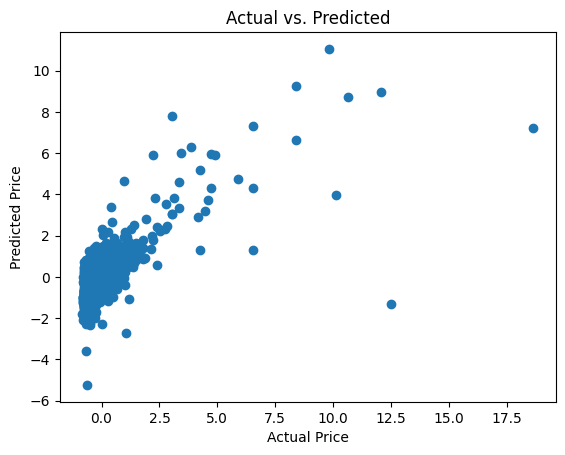

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.show()

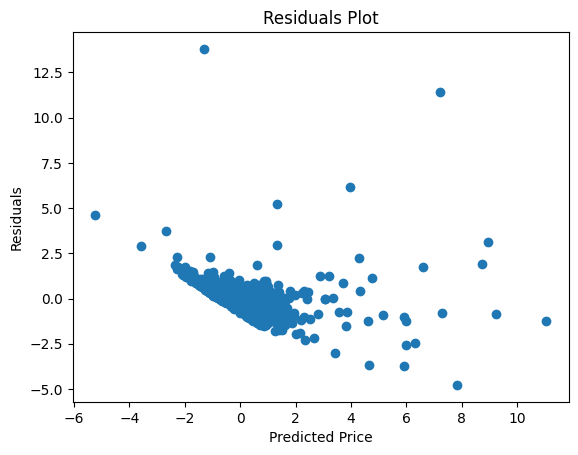

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

# Best Results (mostly because random forest does best with non-linear relationaships)

Random Forest - Mean Squared Error: 0.17768051939615048
Random Forest - R^2 Score: 0.8393970964815066


# Model Selection and Fine Tuning

In [12]:
import pandas as pd
import numpy as np

In [13]:
#Reading in the clean and encoded csv
url = 'https://raw.githubusercontent.com/AutoTrend-Dynamics/COMP3610-Final-Project/refs/heads/main/data/Cleaned_and_Encoded_Cars.csv'
df = pd.read_csv(url)
df.head()

,Title,Dealer,Rating,Exterior Color,Interior Color,Engine,Mileage,Price,Year,Car Age,...,Safety Features_Backup Camera,Safety Features_Blind Spot Monitor,Safety Features_Brake Assist,Safety Features_LED Headlights,Safety Features_Lane Departure Warning,Safety Features_Rain Sensing Wipers,Safety Features_Rear Cross Traffic Alert,Safety Features_Stability Control,Safety Features_Unknown,Safety Features_Missing
0,Chrysler F-58,Gateway Classic Cars,2.4,Red,White,4 Cylinder,-0.225739,-0.632087,-12.620677,99,...,0,0,0,0,0,0,0,0,1,0
1,Ford Model A Base,Skyway Classics,2.9,Magenta,Tan,350 V8,-0.448202,-0.128626,-12.083210,95,...,0,0,0,0,0,0,0,0,1,0
2,Ford Pickup Truck Base,Greenwood Automotive,4.9,–,–,–,2.191959,0.981138,-10.739543,85,...,0,0,0,0,0,0,0,0,1,0
3,Chevrolet Fleetline Deluxe,California Cars,4.6,Atomic Orange Metallic,Gray,283 V8,-0.778631,-0.253931,-9.261509,74,...,0,0,0,0,0,0,0,0,1,0
4,GMC Suburban,Exotic Motorsports of Oklahoma,4.6,Black,Tan,5.7L V8,-0.775992,0.158074,-9.127142,73,...,0,0,0,0,0,0,0,0,1,0


In [14]:
#Encodes the remaining non-numeric columns such as Make so they can be used for predictions
def one_hot_encode_non_numeric(df, drop_first=False):
    #Select non-numeric columns
    non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    #Apply one-hot encoding to those columns and drop them from the original
    df_encoded = pd.get_dummies(df, columns=non_numeric_cols, drop_first=drop_first,dtype=int)

    return df_encoded

In [15]:
df = df.drop(['Title', 'Dealer'], axis=1) #drops the Title and Dealer columns as they will not be used for prediction

In [16]:
df = one_hot_encode_non_numeric(df) #applies the one hot encode function to all non-numeric features

In [17]:
df.columns = df.columns.str.replace(r"[\[\]<>]", "", regex=True) #Removes any special characters so the machine learning models can access them


In [18]:
#Separate the feature matrix from the target variable
X = df.drop('Price', axis=1)
y = df['Price']

In [19]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [10]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [1]:
#Function used to easily evaluate models based on MAE, MSE, RMSE AND R²
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

#Function to train, predict, and evaluate regression models
def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    """Train, predict and evaluate a regression model."""
    X_train = X_train.select_dtypes(include=['number'])
    #print(X_train)
    X_test = X_test.select_dtypes(include=['number'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nEvaluating {model.__class__.__name__}:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R-squared (R²): {r2_score(y_test, y_pred):.4f}")

    #Plot predictions vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='dodgerblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted for {model.__class__.__name__}')
    plt.grid(True)
    plt.show()


## Base Models

Linear Regression, Lasso Regression, XGBoost, Random Forest and MLP will be experimented with.

Linear will be utilized due to its simplicity, interpretability, and efficiency
when modeling linear relationships as well as its ability to act as a strong baseline for comparison against more complex models.

Lasso will be utilized due to its ability to perform feature selection by shrinking less important coefficients to zero, thus reducing overfitting and improving generalization which is particulary useful for complex datasets.

XGBoost will be utilized due to its high predictive performance, regularization capabilities, and robustness and strong support for feature importance

Random forest will be utilized due to its accuracy and stability as well as its effectiveness in handling both linear and non-linear relationships.

MLP will be utilized due to its capacity to identify complex non-linear patterns via deep architectures and its ability to capture interactions that traditional models might miss.





### Linear Regression


Evaluating LinearRegression:
Mean Absolute Error (MAE): 0.2368
Mean Squared Error (MSE): 0.4678
Root Mean Squared Error (RMSE): 0.6840
R-squared (R²): 0.5771


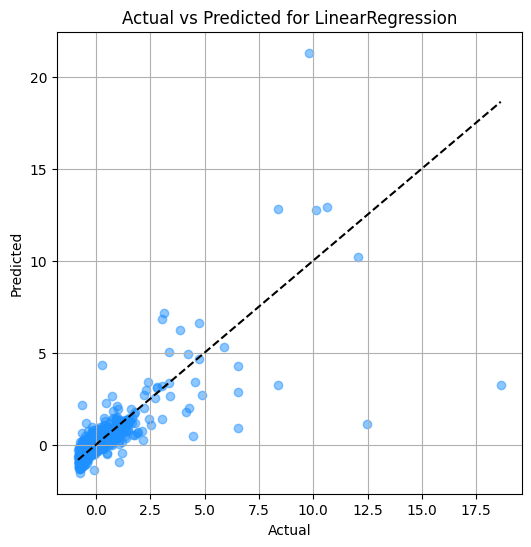

In [12]:
evaluate_regression_model(LinearRegression(), X_train, y_train, X_test, y_test)


From the metrics above, it can be seen that linear regression performs poorly on the data. Utilizing the R² score, it is seen that the model explains only 57.7% of the variance in the target variable. MSE and RMSE also indicate relatively poor predictive performance.


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1317
Mean Squared Error (MSE): 0.1762
Root Mean Squared Error (RMSE): 0.4198
R-squared (R²): 0.8407


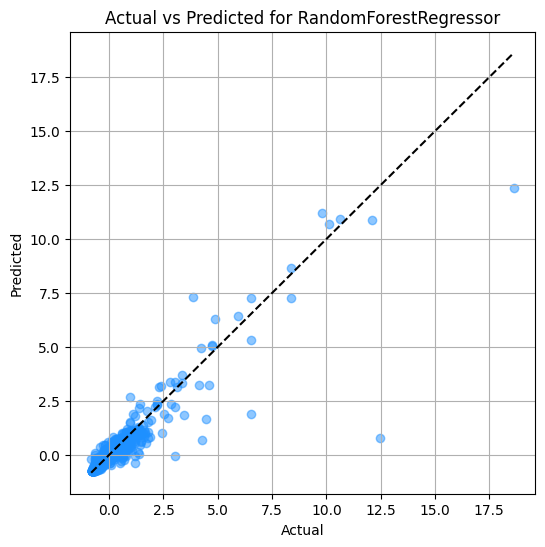

In [ ]:
evaluate_regression_model(RandomForestRegressor(), X_train, y_train, X_test, y_test) #Random Forest Model


From the metrics above, it is clear that the RandomForestRegressor performs significantly better than linear regressionon. The R² score shows that the model explains 84.1% of the variance in the target variable which indicates a strong fit. The lower MAE, MSE, and RMSE values also show improved predictive performance.


Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.1379
Mean Squared Error (MSE): 0.1758
Root Mean Squared Error (RMSE): 0.4193
R-squared (R²): 0.8411


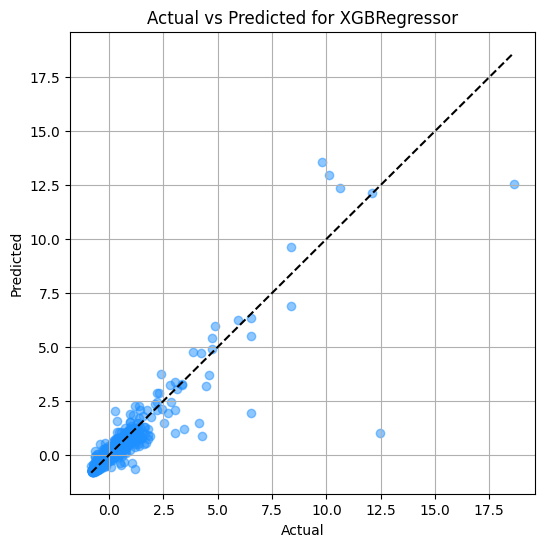

In [ ]:
evaluate_regression_model(XGBRegressor(n_estimators=200, random_state=42), X_train, y_train, X_test, y_test)


From the metrics above, it is seen that the XGBRegressor also performs very well. With an R² score of 84.1%, it explains a large portion of the variance in the target variable. The MAE, MSE, and RMSE values are all low, indicating performance that is comparable to the RandomForestRegressor and better than Linear Regression model.


Evaluating Lasso:
Mean Absolute Error (MAE): 0.3970
Mean Squared Error (MSE): 0.9340
Root Mean Squared Error (RMSE): 0.9664
R-squared (R²): 0.1558


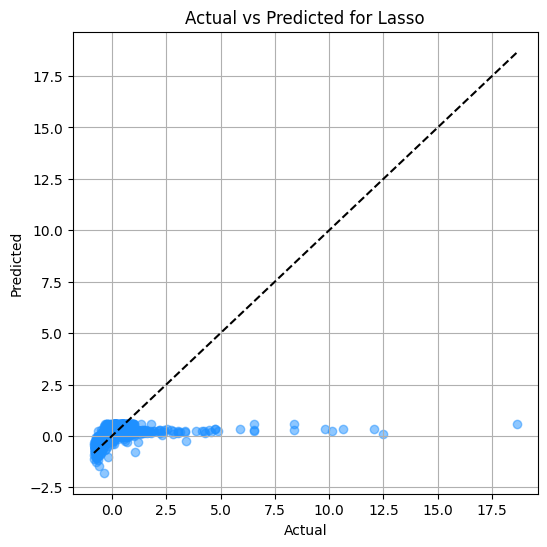

In [ ]:
evaluate_regression_model(Lasso(alpha=0.1), X_train, y_train, X_test, y_test)


From the metrics above, it can be seen that Lasso Regression performs poorly on the data. The R² score of 15.6% indicates that the model explains very little of the variance in the target variable. Additionally, the high MAE, MSE, and RMSE values highlight its weak predictive performance.


Evaluating MLPRegressor:
Mean Absolute Error (MAE): 0.1414
Mean Squared Error (MSE): 0.2148
Root Mean Squared Error (RMSE): 0.4635
R-squared (R²): 0.8058


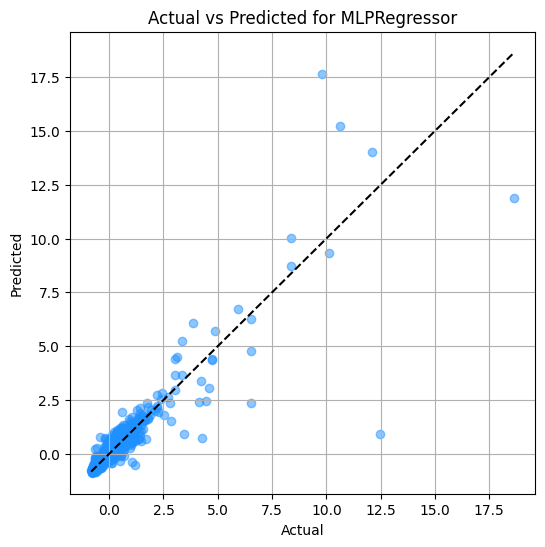

In [ ]:
from sklearn.neural_network import MLPRegressor

model_mlp = MLPRegressor(
    hidden_layer_sizes=(200, 150, 100, 50),  #4 hidden layers, decreasing size
    activation='relu',
    solver='adam',
    max_iter=1000,         #Increased iterations to help deeper net converge
    random_state=42
)

evaluate_regression_model(model_mlp, X_train, y_train, X_test, y_test)


From the metrics above, it is seen that the MLPRegressor also performs well. With an R² score of 80.6%, it explains a significant portion of the variance in the target variable. The MAE, MSE, and RMSE values are relatively low, indicating decent predictive performance, but is slightly less accurate than the XGBRegressor and Random Forest models.

## GridSearch
Used to automate the training of models to determine the best hyperparameters, and provide a guide for manual hyperparameter tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
from sklearn.model_selection import ParameterGrid, KFold
from tqdm import tqdm
#Grid of hyperparameters to try for RandomForest
param_grid = {
    'n_estimators': [100, 200], #Number of trees
    'max_depth': [None, 10, 20],#Max depth per tree
    'min_samples_split': [2, 5],#Minimum samples needed to split a node
    'min_samples_leaf': [1, 2] # #Minimum samples needed at a leaf
}

#5-fold cross-validation with shuffling
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Generate all possible hyperparameter combinations
grid = list(ParameterGrid(param_grid))

results = []

for params in tqdm(grid, desc="Grid Search Progress"):
    model = RandomForestRegressor(random_state=42, **params)
    fold_scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        fold_scores.append(rmse)

    avg_rmse = np.mean(fold_scores)
    results.append((params, avg_rmse))

#Sort by best score
best_params, best_score = sorted(results, key=lambda x: x[1])[0]
print("Best Params:", best_params)
print("Best CV RMSE:", best_score)


Grid Search Progress: 100%|██████████| 24/24 [3:38:35<00:00, 546.46s/it]

Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV RMSE: 0.3700986428882146


The best parameters were {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} which yielded a RMSE of 0.37001

## Grid Search for XGBoost

Cross-validation MSE scores: [-0.10966527 -0.14791969 -0.11845791 -0.17323077 -0.24951577]
Mean cross-validation MSE: -0.1598


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Evaluating XGBoost model:
Mean Absolute Error (MAE): 0.1293
Mean Squared Error (MSE): 0.1710
Root Mean Squared Error (RMSE): 0.4136
R-squared (R²): 0.8454


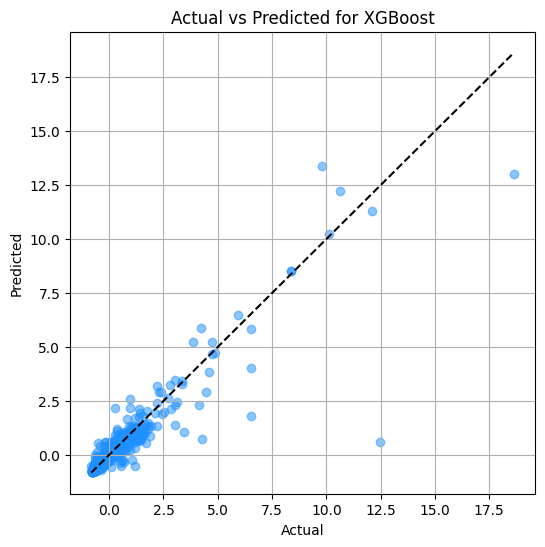

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(random_state=42)

#Perform cross-validation on the training data with 5 folds
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

#Print cross-validation scores
print(f"Cross-validation MSE scores: {cv_scores}")
print(f"Mean cross-validation MSE: {np.mean(cv_scores):.4f}")

#Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

#Use GridSearchCV to tune hyperparameters on training data
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(X_train, y_train)

#Get the best model
best_xgb_model = grid_search.best_estimator_

#Evaluate the best XGBoost model on held out test set
y_pred = best_xgb_model.predict(X_test)

#Evaluation Metrics
print(f"\nEvaluating XGBoost model:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R-squared (R²): {r2_score(y_test, y_pred):.4f}")

#Predictions vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted for XGBoost')
plt.grid(True)
plt.show()


The performance for XGBoost is very competitive with that of Random Forest, therefore manual tuning will be done in order to save time while attempting to push these two models to their limits.

# PCA

Explained variance: 0.9504
Number of components: 76

Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.2125
Mean Squared Error (MSE): 0.4861
Root Mean Squared Error (RMSE): 0.6972
R-squared (R²): 0.5606


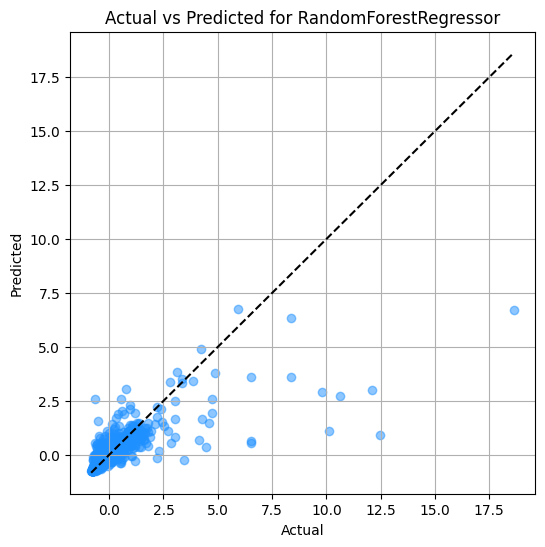

In [ ]:
from sklearn.decomposition import PCA

#Apply PCA to features
pca = PCA(n_components=0.95)  #Retain 95% variance
X_pca = pca.fit_transform(X)

print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Number of components: {X_pca.shape[1]}")

#Convert PCA output to df
X_pca_df = pd.DataFrame(X_pca)

#Train-test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

#Train and evaluate Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
evaluate_regression_model(rf_model, X_train_pca, y_train, X_test_pca, y_test)


From the metrics above, it can be seen that the Random Forest model performs considerably worse after PCA.

Explained variance: 0.9504
Number of components: 76

Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.2230
Mean Squared Error (MSE): 0.4033
Root Mean Squared Error (RMSE): 0.6351
R-squared (R²): 0.6355


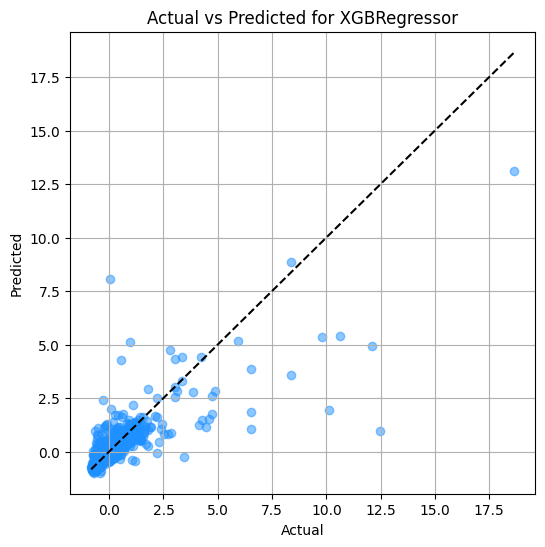

In [11]:
#need to put performance of PCA on xgboost here
from sklearn.decomposition import PCA


# Apply PCA to features
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X)

print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Number of components: {X_pca.shape[1]}")

# Convert PCA output to DataFrame
X_pca_df = pd.DataFrame(X_pca)

# Train-test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

# Train and evaluate XGBoost model
xgb_model = XGBRegressor(random_state=42, n_estimators=100)
evaluate_regression_model(xgb_model, X_train_pca, y_train, X_test_pca, y_test)


From the metrics above, it can be seen that XGBoost also performs considerably worse after PCA.

# Manual Tuning

### Random Forest

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
rf_model = RandomForestRegressor(

    min_samples_leaf=1, #Allows the capturing of complex patterns
    min_samples_split=2, #Allows the capturing of complex patterns
    n_estimators=200, #Higher number of trees may increases robustness and stability
    random_state=42,
    n_jobs=-1
)


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1311
Mean Squared Error (MSE): 0.1773
Root Mean Squared Error (RMSE): 0.4211
R-squared (R²): 0.8397


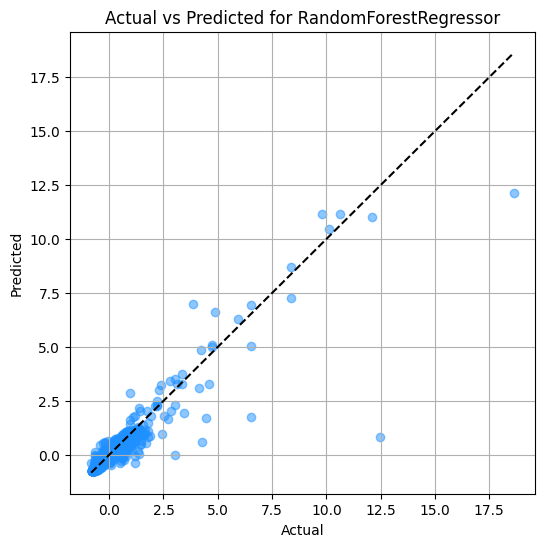

In [ ]:


#Evaluate the model
evaluate_regression_model(rf_model, X_train, y_train, X_test, y_test)

Below the Random Forest Model's n_estimators were increased from 200 to 300 and resulted in an improved performance.


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1302
Mean Squared Error (MSE): 0.1749
Root Mean Squared Error (RMSE): 0.4182
R-squared (R²): 0.8419


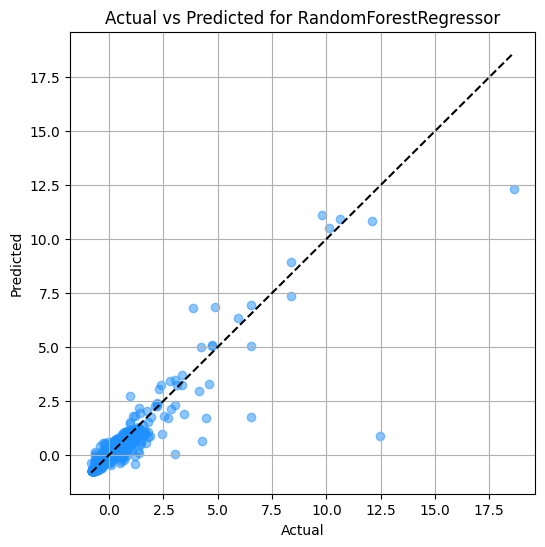

In [ ]:
best_rf_model = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

#Evaluate the model
evaluate_regression_model(best_rf_model, X_train, y_train, X_test, y_test)


From the metrics above, it can be seen that the Random Forest Model with the provided configuration performs the better of the two Random Forest models.

In [20]:
#Define model with maxed-out parameters for XGBoost
model_xgb = XGBRegressor(
    n_estimators=1000,              #Large number of estimators
    max_depth=15,                   #Large max depth for deep trees
    learning_rate=0.01,             #Small learning rate for slow but steady learning
    subsample=0.8,                  #Sample 80% of data for each tree
    colsample_bytree=0.8,           #Randomly sample features per tree
    reg_alpha=1.0,                  #L1 regularization
    reg_lambda=1.0,                 #L2 regularization
    gamma=0.1,                      #Minimum loss reduction required to make a further partition
    min_child_weight=1,             #Minimum sum of instance weight needed in a child
    scale_pos_weight=1,             #Balance of positive and negative weights
    random_state=42,
    verbosity=1,
    objective='reg:squarederror'
)



Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.1342
Mean Squared Error (MSE): 0.1559
Root Mean Squared Error (RMSE): 0.3949
R-squared (R²): 0.8591


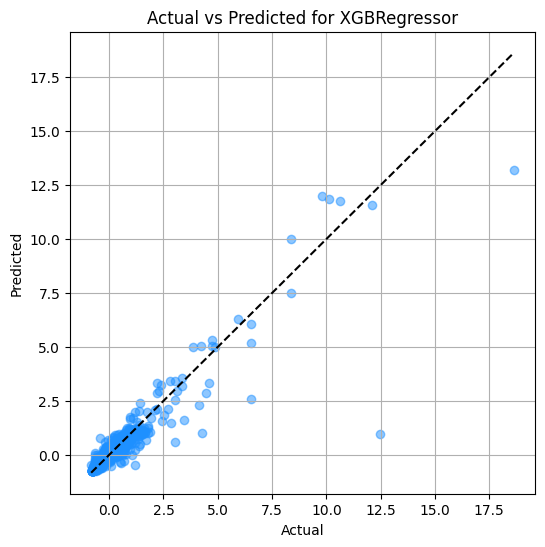

In [ ]:
#Train and evaluate
evaluate_regression_model(model_xgb, X_train, y_train, X_test, y_test)

The above model is the best performing, with an R² of 0.8591, indicating strong predictive power and low error metrics across MAE, MSE, and RMSE

Confirming the performance of the XGBoost model using cross validation.

In [ ]:
def xgb_with_cv(X_train, y_train, X_test, y_test):
    model_params = {
        'n_estimators': 1000,
        'max_depth': 15,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1.0,
        'reg_lambda': 1.0,
        'gamma': 0.1,
        'min_child_weight': 1,
        'scale_pos_weight': 1,
        'random_state': 42,
        'verbosity': 1,
        'objective': 'reg:squarederror'
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_list, rmse_list, r2_list = [], [], []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr = X_tr.select_dtypes(include='number')
        X_val = X_val.select_dtypes(include='number')

        model = XGBRegressor(**model_params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        mae_list.append(mean_absolute_error(y_val, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        r2_list.append(r2_score(y_val, y_pred))

    print("Average CV MAE:", np.mean(mae_list))
    print("Average CV RMSE:", np.mean(rmse_list))
    print("Average CV R²:", np.mean(r2_list))

    #Final test evaluation
    X_train_filtered = X_train.select_dtypes(include='number')
    X_test_filtered = X_test.select_dtypes(include='number')

    final_model = XGBRegressor(**model_params)
    final_model.fit(X_train_filtered, y_train)
    y_test_pred = final_model.predict(X_test_filtered)

    print("\nTest Set Results:")
    print("MAE:", mean_absolute_error(y_test, y_test_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print("R²:", r2_score(y_test, y_test_pred))

    #Actual vs Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='dodgerblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Test Set: Actual vs Predicted")
    plt.grid(True)
    plt.show()


Average CV MAE: 0.1373629714523205
Average CV RMSE: 0.379974859389906
Average CV R²: 0.8462598935913735

Test Set Results:
MAE: 0.13419719921257386
RMSE: 0.39487783122262016
R²: 0.8590584371211714


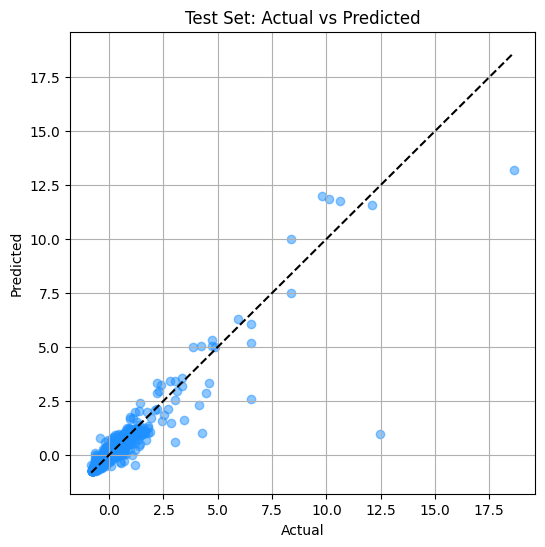

In [ ]:
xgb_with_cv(X_train, y_train, X_test, y_test)

Overall, cross-validation has confirmed that the xgboost model performs well across all folds, and is suitable for api and dashboard implementation.

# Reducing Features


## Using Rating, Mileage, Year and Engine-related features

In [40]:
X = ['Rating', 'Mileage', 'Year']
make_cols = [col for col in df.columns if col.startswith("Make")]
engine_cols = [col for col in df.columns if col.startswith("Engine")]

X = df[X + make_cols + [col for col in engine_cols if col not in X]]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1512
Mean Squared Error (MSE): 0.2055
Root Mean Squared Error (RMSE): 0.4533
R-squared (R²): 0.8143


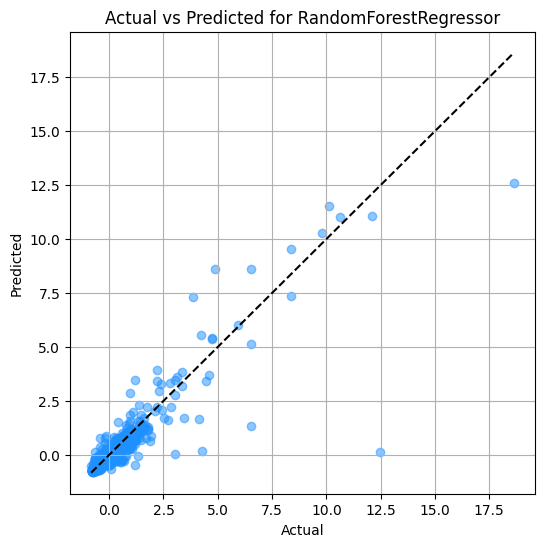

In [34]:
evaluate_regression_model(rf_model, X_train, y_train, X_test, y_test)


Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.1666
Mean Squared Error (MSE): 0.2103
Root Mean Squared Error (RMSE): 0.4585
R-squared (R²): 0.8100


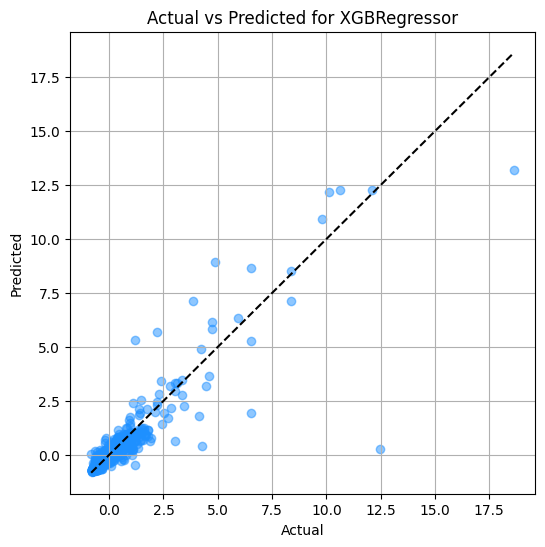

In [35]:
evaluate_regression_model(model_xgb, X_train, y_train, X_test, y_test)

Both Random Forest and XGBoost perform well given this particular subset of features, but many of the Engine columns may be difficult to implement via an API, therefore simpler features need to be considered while also retaining as much performance as possible.

### Rating, Mileage, Year, Make and EngineType

These features are very simple and can be understood by stakeholders such as managers and marketing teams.

In [25]:
X = ['Rating', 'Mileage', 'Year']
make_cols = [col for col in df.columns if col.startswith("Make")]
engine_type_cols = [col for col in df.columns if col.startswith("EngineType")]

X = df[X + make_cols + [col for col in engine_type_cols if col not in X]]


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.2163
Mean Squared Error (MSE): 0.2717
Root Mean Squared Error (RMSE): 0.5213
R-squared (R²): 0.7544


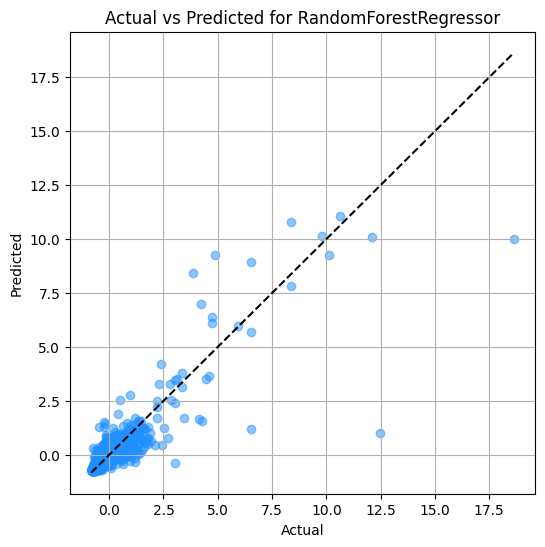

In [27]:
evaluate_regression_model(rf_model, X_train, y_train, X_test, y_test)


Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.2239
Mean Squared Error (MSE): 0.2753
Root Mean Squared Error (RMSE): 0.5247
R-squared (R²): 0.7512


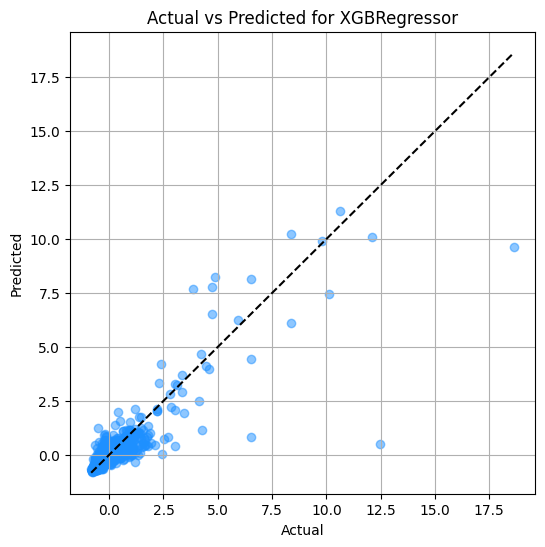

In [30]:
evaluate_regression_model(model_xgb, X_train, y_train, X_test, y_test)

These features have provided considerably worse metrics compared to the ideal XGBoost model which had an RMSE of 0.3949 and R² of 0.8591, but given that it was a tradeoff between simplicity and performance, and the model still performs decently, it will be chosen for the API implementation. Using this configuration, Random Forest will be used since it slightly outperforms the XGBoost model.